# Libraries

In [65]:
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
from scipy import signal, linalg

from numpy.linalg import inv
from scipy.optimize import fmin_bfgs
import pandas as pd
from pandas import read_csv
import time

import pylab

plt.rcParams['figure.figsize'] = (10,6)

# Simulation Function

In [40]:
def simulate(datagen, N, arma, n, m, k , q, projection=True):
    # n : number of simulations
    # N : length of the simulations
    # arma : expected a function such as : arma_ons, amra_ogd...
    #############
    
    list_sim_loss = []
    list_sim_nabla = []
    list_sim_L = []
    
    for i in range(n):
        # simulate data
        X = datagen(N)
        # get historical parameter and loss
 
        X_p, loss_hist, nabla_hist, L_hist = arma(X, m, k, q, projection)
        
        list_sim_loss.append(loss_hist)
        list_sim_nabla.append(nabla_hist) 
        list_sim_L.append(L_hist)
        
    return np.array(list_sim_loss), np.array(list_sim_nabla), np.array(list_sim_L)

# ARMA OGD

In [41]:
def arma_ogd(X, m, k, q, projection = True):
    """
    ARMA online gradient descent
    """
    #New Implementation
    
    c = 1
    D = np.sqrt(2*(m+k))
    G = 2*np.sqrt(m+k)*D
    T = X.shape[0]
    rate = D/(G*np.sqrt(T))

    L = np.random.uniform(-0.5, 0.5, (m+k, 1))
    L = np.matrix(L)

    X_p = np.zeros(T)
    loss = np.zeros(T)
    nabla_norm_hist = np.zeros(T)
    L_hist = np.zeros(T)
    for t in range(T):
        #predict
        X_t = 0
        for i in range(m+k):
            if t-i-1 < 0:
                break
            X_t += L[i]*X[t-i-1]
        X_p[t] = X_t

        #loss
        loss[t] = (X[t]-X_t)**2

        #update
        nabla = np.zeros((m+k, 1))
        for i in range(m+k):
            x = X[t-i-1] if t-i-1 >= 0 else 0
            nabla[i, 0] = -2*(X[t]-X_t)*x
        nabla_norm_hist[t] = np.linalg.norm(nabla, 2)
        
        L = L - rate*nabla
        
        if projection:
            L_norm = max(L.max(), -L.min())
            if L_norm > c:
                L /= L_norm
                L *= c
            
        L_hist[t] = L.max()
        
    return X_p, loss, nabla_norm_hist, L_hist

# ARMA ONS

In [42]:
def arma_ons(X, m, k, q, projection = True):
    """
    arma online newton step
    """
    #new
    c = 1
    
    
    D = np.sqrt(2*(m+k))
    G = 2*np.sqrt(m+k)*D
    rate = 0.5*min(1./(m+k), 4*G*D)
    epsilon = 1./(rate**2 * D**2)
    A = np.diag([1]*(m+k)) * epsilon
    A = np.matrix(A)
    T = X.shape[0]

    L = np.random.uniform(-0.5, 0.5, (m+k, 1))
    L = np.matrix(L)

    X_p = np.zeros(T)
    loss = np.zeros(T)
    
    #New
    nabla_norm_hist = np.zeros(T)
    #New
    L_hist = np.zeros(T)
    
    for t in range(T):
        #predict
        X_t = 0
        for i in range(m+k):
            if t-i-1 < 0:
                break
            X_t += L[i]*X[t-i-1]
        X_p[t] = X_t

        #loss
        loss[t] = (X[t]-X_t)**2

        #update
        nabla = np.zeros((m+k, 1))
        for i in range(m+k):
            x = X[t-i-1] if t-i-1 >= 0 else 0
            nabla[i, 0] = -2*(X[t]-X_t)*x
        
        #New
        nabla_norm_hist[t] = np.linalg.norm(nabla, 2)
        
        A = A + np.dot(nabla, nabla.T)
        # y = L - 1/rate*np.dot(inv(A), nabla)
        # L = fmin_bfgs(K_min(y, A), L)
        # L = np.matrix(L).reshape(-1, 1)
        L = L - 1/rate*np.dot(inv(A), nabla)
        
        #New
        if projection:
            L_norm = max(L.max(), -L.min())
            if L_norm > c:
                L /= L_norm
                L *= c
            
        L_hist[t] = L.max()
        
    return X_p, loss, nabla_norm_hist, L_hist

# Plot Simulations

In [43]:
def plot_simulations_results(title, arma, data_gen, k, q, T=1000, iters=200):
    t0 = time.time()

    print(title)

    
    m = 5
    sim_loss, sim_nabla, sim_L = simulate(data_gen, T, arma, iters, m, k, q, projection=True)

    plt.subplot(221, )
    moy_loss = sim_loss.mean(axis=0) #gen_errors(loss)
    plt.plot(moy_loss)
    plt.ylim(ymax=1.6, ymin=-0)
    plt.title("Loss")
    
    print("time : {}".format(round(time.time()-t0, 2)))
    return sim_loss, sim_nabla, sim_L

# Plot Data

In [44]:
# List to record simulation results.
ONS_sim_loss = [[]]*6
ONS_sim_L = [[]]*6

OGD_sim_loss = [[]]*6
OGD_sim_L = [[]]*6

YL_sim_loss = [[]]*6

#New sim loss
RL_sim_loss = [[]]*6

# Sanity Check

In [45]:
def gen_dataset1(n_samples=10000):
    alpha = np.array([0.6, -0.5, 0.4, -0.2, 0.3])
    beta = np.array([0.3, -0.2])
    a = 5
    b = 2
    sigma = 0.3

    noises = [0]*b
    arma = [0]*a
    for i in range(n_samples):
        noise = np.random.normal(0, sigma)
        x = np.sum(arma[:-a-1:-1] * alpha)
        x += np.sum(noises[:-b-1:-1] * beta)
        x += noise
        arma.append(x)
        noises.append(noise)
    arma = np.array(arma[a:])
    return arma

Red Curve: Simulated Data
Blue curve: predicted values


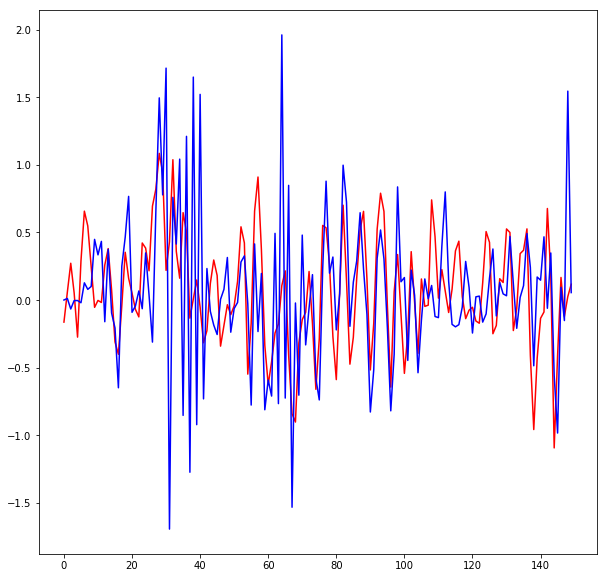

In [46]:
X = gen_dataset1(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Red Curve: Simulated Data")
print("Blue curve: predicted values")

### OGD Simulation

ARMA-OGD
time : 97.81


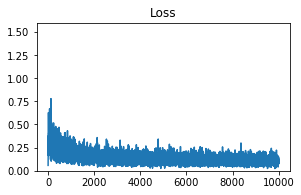

In [75]:
OGD_sim_loss[0], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset1, k=5, q=2, T=10000, iters=20)

### ONS Simulation

ARMA-ONS
time : 104.93


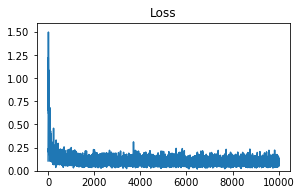

In [76]:
ONS_sim_loss[0], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset1, k=5, q=2, T=10000, iters=20)

### Comparison Graph

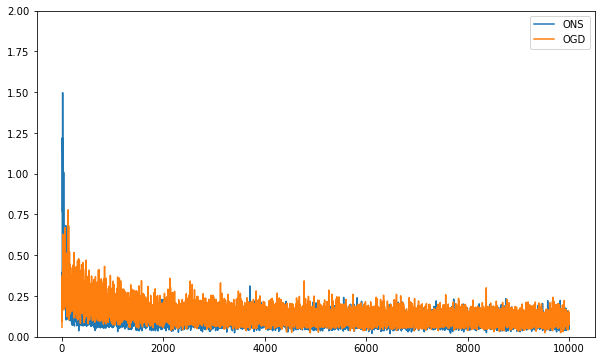

In [77]:
pylab.plot(ONS_sim_loss[0].mean(0), label = 'ONS')
pylab.plot(OGD_sim_loss[0].mean(0), label = 'OGD')
pylab.legend(loc = 'upper right')
pylab.ylim(0.0,2)
pylab.show()

# Performance Check

### ONS Check

In [78]:
(ONS_sim_loss[0].mean(0)).mean()

0.10561468699626268

### OGD Check

In [79]:
(OGD_sim_loss[0].mean(0)).mean()

0.13533539695691033

# Smoothing

# ONS Smooth

/Users/siddharth/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


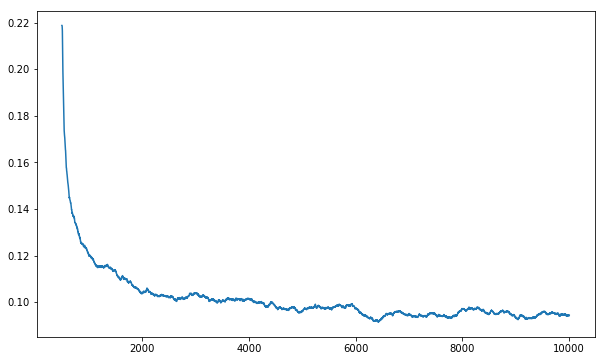

In [80]:
smooth_data_ONS = pd.rolling_mean(ONS_sim_loss[0].mean(0),500)
pylab.plot(smooth_data_ONS)

# OGD Smooth

/Users/siddharth/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


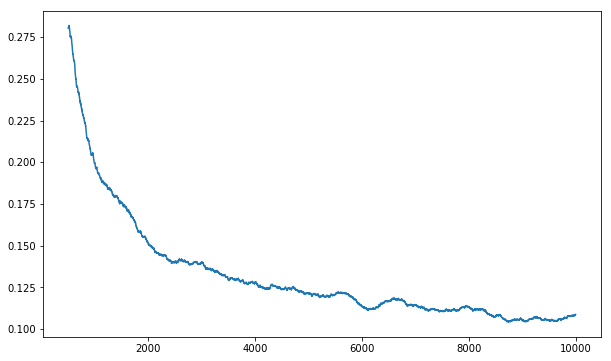

In [81]:
smooth_data_OGD = pd.rolling_mean(OGD_sim_loss[0].mean(0),500)
pylab.plot(smooth_data_OGD)

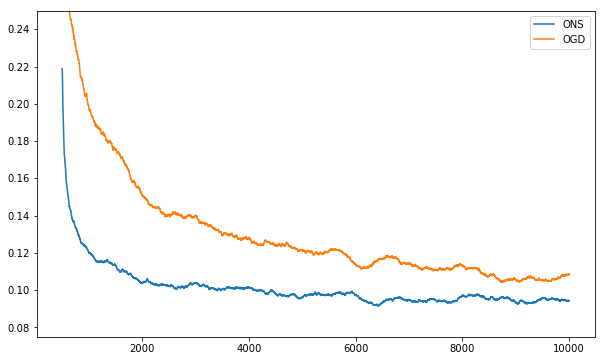

In [82]:
pylab.plot(smooth_data_ONS, label = 'ONS')
pylab.plot(smooth_data_OGD, label = 'OGD')
pylab.legend(loc = 'upper right')
pylab.ylim(0.075,0.25)
#pylab.xlim(0.0,3000)
pylab.show()